In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Experiments

In [5]:
restart_experiments = True
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans']
list_n_cluster = np.arange(2,8,1)
random_seeds = np.random.randint(high=200, low=1, size=2)
random_seeds

array([164, 130])

In [6]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(len(random_seeds)):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [ ]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(len(random_seeds)):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
        dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
        dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score

In [65]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(len(random_seeds)):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('results/clustering/results_clustering.csv', index=False)
  df_results.head()

In [100]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('results/clustering/results_clustering_agg.csv', index=False)
  df_results_agg.head()

,method,number_cluster,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std
0,gmm_diag,2,0.154029,8395.824739,-106780.866619,2.286610,0.000000,0.000000,0.138449,0.000000
1,gmm_diag,3,0.059731,5108.198196,-122785.554552,2.934360,0.000092,5.301687,13.653701,0.003194
2,gmm_diag,4,0.038056,4134.096548,-155787.174903,4.098435,0.008555,9.270272,89.788835,0.550563
3,gmm_diag,5,0.030972,3835.955321,-162519.727066,3.604832,0.000237,6.813459,9.585374,0.004742
4,gmm_diag,6,0.036531,3717.274257,-167213.766943,3.243810,0.000410,0.104307,13.323769,0.004677


In [ ]:
if restart_experiments == False:
  df_results = pd.read_csv('results/clustering/results_clustering.csv')
  df_results_agg pd.read_csv('results/clustering/results_clustering_agg.csv')

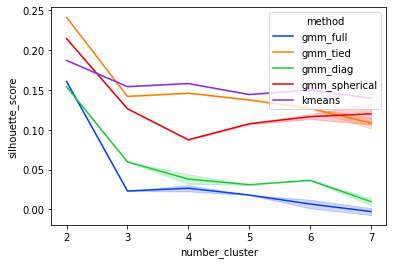

In [95]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1

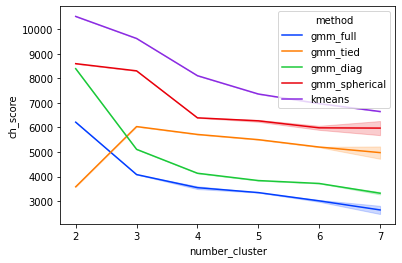

In [96]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize

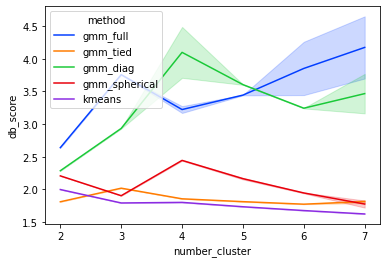

In [97]:
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero

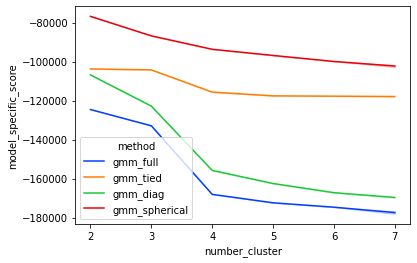

In [98]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow

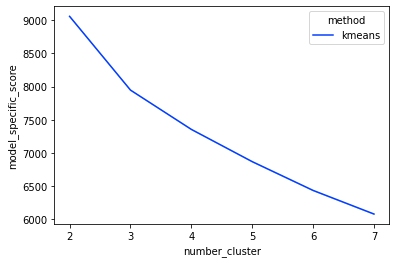

In [99]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

In [ ]:
df_results[df_results['number_cluster'] == 2]


# vorher Code so anpassen, dass wir 10 mal den gesamten Prozess durchlaufen und in DataFrame speichern (zusatzinfos: Iteration & Random Seed)
# Dabei Gruppenzuordnung in extra file auf dem Laufwerk speichern
# Anschließend basierend auf den Label den Rand Score berechnen
# --------------
# Ranking je Score bestimmen und dann Average Ranking je Methode & Cluster (Auswahl beste Methode je Cluster)
# Erstmal nur für Cluster Zahl 2, 3 & 5 
# Clusterzahl 2, da besten Scores & Auswahl der Methode nach Average Ranking
# Clusterzahl 3, da k-means elbow (Ergebnis des modellspezifischen Plots)
# Clusterzahl 5, da BIC elbow (Ergebnis des modellspezifischen Plots)

# Test Rand Score

In [ ]:
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans']
avg_rand_scores = []
for n_cluster in list_n_cluster:
  cum_rand_scores = 0
  for method_1 in methods:
    df_1 = pd.read_csv('data/clustering/' + method_1 +'_' + str(n_cluster) + '.csv')
    labels_1 = df_1['group'].to_numpy()
    for method_2 in methods:
      df_2 = pd.read_csv('data/clustering/' + method_2 +'_' + str(n_cluster) + '.csv')
      labels_2 = df_2['group'].to_numpy()
      rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
      
      #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
      cum_rand_scores = cum_rand_scores + rand_score
  avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
  avg_rand_scores.append(avg_rand_score)
  print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

In [ ]:
plt.plot(list_n_cluster, avg_rand_scores)
plt.show()